## HUDF with astropy
#### import numpy, sep and astropy

In [21]:
import numpy as np
import sep
import astropy.io.fits as ast

#### import matplotlib libraries
#### additional setup for reading the test image and displaying plots

In [22]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

rcParams['figure.figsize'] = [10.,8.]

#### read image into standard 2-d numpy array

In [23]:
with ast.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data = hdul[0].data

#### show the image

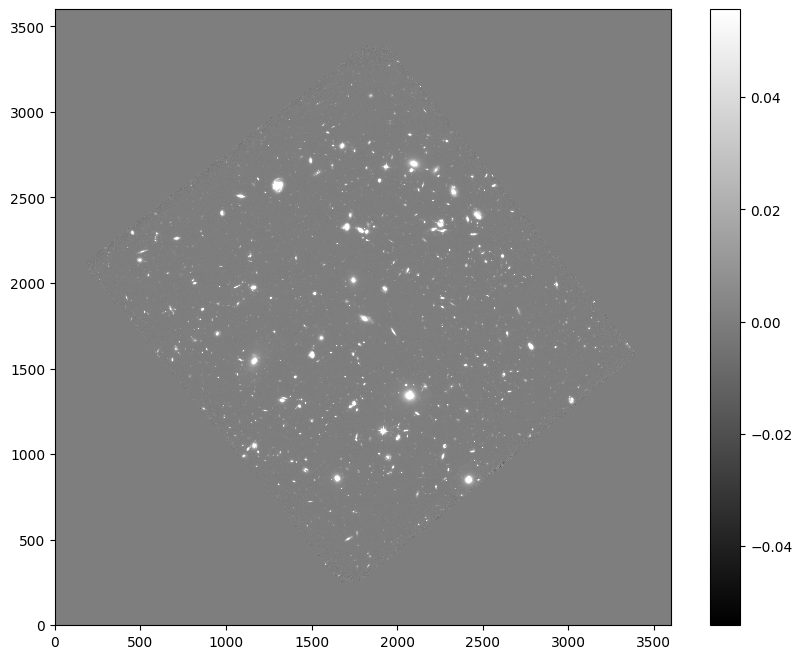

In [24]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation = "nearest", cmap = "gray", vmin = m -s, vmax = m + s, origin = "lower")
plt.colorbar();
plt.savefig("image1_hudf.png", bbox_inches = "tight", dpi = 400)

#### measure a spatially varying background on the image

In [25]:
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

#### get a "global" mean and noise of the image background:

In [26]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


#### evaluate background as 2-d array, same size as original image

In [27]:
bkg_image = bkg.back()
#bkg_image = np.array(bkg) is the same

#### show the background

In [ ]:
plt.imshow(bkg_image, interpolation = "nearest", cmap = "gray", origin = "lower")
plt.colorbar();
plt.savefig("image2_hudf.png", bbox_inches = "tight", dpi = 400)

#### evaluate the background noise as 2-d array, same size

In [ ]:
bkg_rms = bkg.rms()

In [ ]:
#show the background noise
plt.imshow(bkg_rms, interpolation = "nearest", cmap = "gray", origin = "lower")
plt.colorbar();
plt.savefig("image3_hudf.png", bbox_inches = "tight", dpi = 400)

#### subtract the background

In [ ]:
data_sub = data - bkg
#or bkg.subfrom(data)

#### run object detection on the background-subtracted data

In [ ]:
objects = sep.extract(data_sub, 1.5, err = bkg.globalrms)

#### sep.extract hasmany options for controlling detection threshold, pixel masking, filtering and object deblending
#### objects is a NumPy structured array with many fields

In [ ]:
#how many objects were detected
len(objects)

#### to check where the detected objects are, we'll over-plot the object coordinates with some basic shape parameters on the image

In [ ]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation = "nearest", cmap = "gray", vmin = m - s, vmax = m + s, origin = "lower")

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy = (objects["x"][i], objects["y"][i]), width = 6*objects["a"][i], height = 6*objects["b"][i], angle = objects["theta"][i] * 180. / np.pi)
    e.set_facecolor("none")
    e.set_edgecolor("red")
    ax.add_artist(e)

plt.savefig("image4_hudf.png", bbox_inches = "tight", dpi = 400)

#### available fields

In [ ]:
objects.dtype.names

#### perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects["x"], objects["y"], 3.0, err = bkg.globalrms, gain = 1.0)
#flux, fluxerr and flag are all 1-d arrays with one entry per objects

#### show the first 10 objects results:

In [ ]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

In [ ]:
#fluxes = np.linspace(0, flux[8639], len(objects))
plt.hist(flux, bins = 10000, edgecolor = "black", alpha = 0.5)
plt.xlabel("flux")
plt.ylabel("frequency")
plt.xscale("symlog")
plt.title("flux histogram")

plt.savefig("HUDF_hist.png", bbox_inches = "tight", dpi = 400)

plt.show()

In [ ]:
#mean, median and std of fluxes
f_mean = np.mean(flux)
f_median = np.median(flux)
f_std = np.std(flux)

print(f"Mean: {f_mean}\nMedian: {f_median}\nStandard Deviation: {f_std}")

In [ ]:
#largest outlier
f_outlier = np.abs(flux - f_mean) > 2 * f_std
f_out_ind = np.argmax(np.abs(flux - f_mean))
f_out_val = flux[f_out_ind]
out_std = (f_out_val - f_mean)/f_std

print(f"Largest Outlier: {f_out_val}\nIndex of Largest Outlier: {f_out_ind}")
print(f"The Largest Outlier is {out_std} Standard Deviations from the Mean")

In [ ]:
#loading fits representing rgb
red_f160w = ast.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
green_f125w = ast.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
blue_f105w = ast.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

rgb_img = np.stack([red_f160w, green_f125w, blue_f105w], axis = -1)

#display
plt.imshow(rgb_img, origin = "lower")
plt.title("false color image")
plt.savefig("HUDF_falsecolor.png", bbox_inches = "tight", dpi = 400)
plt.show()